# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

xНачнем с ReLU, у которого параметров нет.

In [5]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [6]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [7]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [8]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [9]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

In [10]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.001)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down and train and val accuracy go up for every epoch
loss_history, train_history, val_history = trainer.fit()

Loss: 1.981464, Train accuracy: 0.228111, val accuracy: 0.251000
Loss: 1.801773, Train accuracy: 0.410222, val accuracy: 0.423000
Loss: 1.284125, Train accuracy: 0.515333, val accuracy: 0.524000
Loss: 1.342681, Train accuracy: 0.601000, val accuracy: 0.577000
Loss: 1.260655, Train accuracy: 0.664222, val accuracy: 0.636000
Loss: 0.770074, Train accuracy: 0.706000, val accuracy: 0.671000
Loss: 0.956878, Train accuracy: 0.693000, val accuracy: 0.673000
Loss: 0.839628, Train accuracy: 0.717667, val accuracy: 0.675000
Loss: 1.291718, Train accuracy: 0.719111, val accuracy: 0.682000
Loss: 0.939299, Train accuracy: 0.713889, val accuracy: 0.679000
Loss: 1.446909, Train accuracy: 0.757222, val accuracy: 0.709000
Loss: 1.124043, Train accuracy: 0.754333, val accuracy: 0.721000
Loss: 1.035467, Train accuracy: 0.766333, val accuracy: 0.709000
Loss: 1.180259, Train accuracy: 0.762000, val accuracy: 0.705000
Loss: 1.181304, Train accuracy: 0.751889, val accuracy: 0.717000
Loss: 1.155669, Train acc

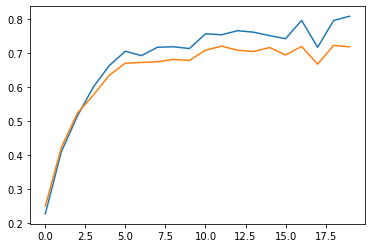

In [11]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [12]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.001)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, learning_rate_decay=1.01)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.156528, Train accuracy: 0.236111, val accuracy: 0.250000
Loss: 2.063751, Train accuracy: 0.425444, val accuracy: 0.418000
Loss: 1.738799, Train accuracy: 0.529667, val accuracy: 0.531000
Loss: 1.029850, Train accuracy: 0.625556, val accuracy: 0.600000
Loss: 1.357826, Train accuracy: 0.666000, val accuracy: 0.649000
Loss: 1.839792, Train accuracy: 0.692444, val accuracy: 0.682000
Loss: 1.048979, Train accuracy: 0.712000, val accuracy: 0.710000
Loss: 1.301110, Train accuracy: 0.712222, val accuracy: 0.675000
Loss: 1.784056, Train accuracy: 0.741000, val accuracy: 0.694000
Loss: 1.031143, Train accuracy: 0.748667, val accuracy: 0.705000
Loss: 0.885317, Train accuracy: 0.741444, val accuracy: 0.707000
Loss: 0.692935, Train accuracy: 0.764667, val accuracy: 0.703000
Loss: 1.542134, Train accuracy: 0.755889, val accuracy: 0.700000
Loss: 0.806335, Train accuracy: 0.774889, val accuracy: 0.707000
Loss: 1.205458, Train accuracy: 0.778222, val accuracy: 0.704000
Loss: 1.283796, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [13]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.001)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-3, learning_rate_decay=1.01)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.252894, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.197961, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315297, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.004465, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.090912, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321703, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.095986, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.174701, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.104525, Train accuracy: 0.198333, val accuracy: 0.209000
Loss: 2.124267, Train accuracy: 0.223111, val accuracy: 0.226000
Loss: 2.044808, Train accuracy: 0.251667, val accuracy: 0.256000
Loss: 2.103631, Train accuracy: 0.261778, val accuracy: 0.260000
Loss: 1.812827, Train accuracy: 0.273667, val accuracy: 0.270000
Loss: 2.039395, Train accuracy: 0.288444, val accuracy: 0.292000
Loss: 1.934147, Train accuracy: 0.316333, val accuracy: 0.325000
Loss: 1.858645, Train acc

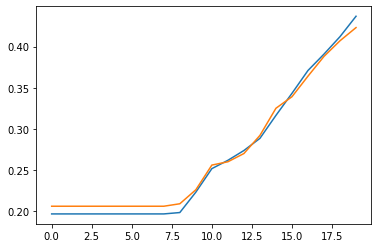

In [14]:
plt.plot(train_history)
plt.plot(val_history)

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [15]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.326207, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.296311, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.272028, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.324880, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.286537, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303686, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.210565, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.117507, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.999537, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.778503, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.660830, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.023748, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.462641, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.065328, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.741440, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.421521, Train acc

Loss: 0.228999, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.210501, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.210876, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.213152, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.220267, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.213064, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.225453, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.221465, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.205337, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.227894, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.220532, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.215665, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.228048, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.217211, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.228547, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.221112, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [48]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.01)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=0.3, learning_rate_decay=0.99, num_epochs=18, batch_size=5)

#сошлось на 18-ти эпохах тренировки!

loss_history, train_history, val_history = trainer.fit()

Loss: 2.294469, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.257295, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.271006, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 2.220039, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.832819, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 1.723938, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.879884, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 1.740961, Train accuracy: 0.466667, val accuracy: 0.133333
Loss: 1.729843, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.074631, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.645414, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 1.170553, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 1.928692, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.329491, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 0.625407, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 1.099170, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [93]:
# Let's train the best one-hidden-layer network we can

# learning_rates = 1e-4
# reg_strength = 1e-3
# learning_rate_decay = 0.999
# hidden_layer_size = 128
# num_epochs = 200
# batch_size = 64

learning_rates = [1.1e-1]
reg_strengths = [1e-3]
learning_rate_decay = [1.008]
hidden_layer_sizes = [22]
num_epochs = [75]
batch_sizes = [64]
best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        for hidden_layer_size in hidden_layer_sizes:
            for num_epoch in num_epochs:
                for batch_size in batch_sizes:
                    
                    model = TwoLayerNet(n_input = train_X.shape[1], 
                                    n_output = 10, 
                                    hidden_layer_size = hidden_layer_size, 
                                    reg = reg_strength)
                    dataset = Dataset(train_X, train_y, val_X, val_y)
                    trainer = Trainer(model, dataset, MomentumSGD(), 
                                      learning_rate=learning_rate, 
                                      num_epochs=num_epoch, batch_size=batch_size)
                    loss_history, train_history, val_history = trainer.fit()
                    if best_classifier == None:
                        best_classifier = model
                        best_val_accuracy = val_history[-1]

                    if best_val_accuracy<best_val_accuracy:
                        best_classifier = model
                        best_val_accuracy = val_history[-1]
                        best_learning_rate = learning_rate
                        best_reg_strength = reg_strength
                        best_hidden_layer_size = hidden_layer_size
                        best_num_epoch = num_epoch
                    print('next')


print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.182625, Train accuracy: 0.284556, val accuracy: 0.309000
Loss: 1.811836, Train accuracy: 0.423444, val accuracy: 0.418000
Loss: 1.629200, Train accuracy: 0.517556, val accuracy: 0.519000
Loss: 1.616976, Train accuracy: 0.595556, val accuracy: 0.604000
Loss: 1.377889, Train accuracy: 0.557333, val accuracy: 0.530000
Loss: 1.266489, Train accuracy: 0.592889, val accuracy: 0.572000
Loss: 1.757086, Train accuracy: 0.561667, val accuracy: 0.562000
Loss: 1.613573, Train accuracy: 0.536556, val accuracy: 0.524000
Loss: 1.884299, Train accuracy: 0.565111, val accuracy: 0.530000
Loss: 1.801029, Train accuracy: 0.585222, val accuracy: 0.560000
Loss: 1.407747, Train accuracy: 0.621111, val accuracy: 0.579000
Loss: 1.384942, Train accuracy: 0.595778, val accuracy: 0.591000
Loss: 1.945659, Train accuracy: 0.583778, val accuracy: 0.558000
Loss: 1.796410, Train accuracy: 0.604000, val accuracy: 0.585000
Loss: 1.910905, Train accuracy: 0.614556, val accuracy: 0.607000
Loss: 1.451375, Train acc

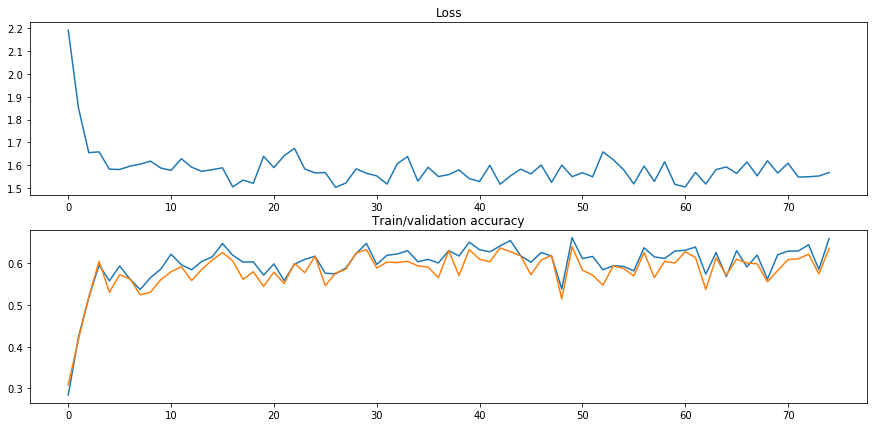

In [94]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [96]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.571000
